# Physics 515 assignment 4
Brittany Howard

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [19]:
# parameters list

tail_percent = 0.02  # the percentage of (p*theta) values outside the gaussian core
sigma_p_coeff = 0.05  # coefficient for resolution of detector (sigma = 0.5p)  
sigma_theta = 0.0005  # resolution of detector
sigma_sigma_theta = 0.00005  # uncertainty on resolution of detector
E_0 = 2.4 # GeV
mass = 2000.  # package mass, grams
sigma_mass = 10.
area = 800.  # package area, cm^2
sigma_area = 1.
X_a = 24.0  # characteristic radiation length, aluminum, g/cm^2
X_u = 6.0  # characteristic raditation length, uranium, g/cm^2
num_test_ws = 10  # number of values of w  for which to run monte carlos
num_monteCarlo = 10*4  # number of monte carlos to run for each w value

## General plan

The overarching goal is to use some test statistic that we can obtain from our data to determine the mass fraction of uranium. What test statistic should we use? As a a heavier element results in a higher degree of scattering, we can say that as the spread of $(p\theta)$ increases, so too would the mass fraction of uranium. Hopefully, this happens in a linear fashion. If we generate fake sets of data using a few different mass fraction values, $\frac{x}{X_0}$, we can evaluate their corresponding test statistics. This is done by plotting $(p*\theta)$ vs count for the simulated data and then finding its variance. This variance is the test statistic $t$. Then we can plot mass fraction vs. test statistic and fit a curve$^1$ to their relationship; once we know this curve, things are simple. All we need to do then is evaluate the test statistic of the given data, and we can use the curve we fit to find its mass fraction of uranium.

Finally, to answer the given question, we just need to calculate $t$ for the test data set and then use the linear fit solve for the mass fraction $w$.

## Generating fake data: theory

### Determining the pdfs of $p$ and $\theta$
The first step will be to generate some fake data sets of $p$ and $\theta$. To do so, we can start with $p$. It follows this pdf:

$f(p_{true}) = \frac{e^{1/E_0}}{E_0}e^{-p/E_0}$, 

with $p \geq 1$ GeV/c and $E_0=2.4$ GeV. This will be the "true" value of p, but we need to account for the detector's resolution. To do so, we will add the outcome of a Gaussian with mean 0 and $\sigma=0.05p$ to the true p-value to get the reported p-value. This gives us:

$f(p_{reported}) = \frac{e^{1/E_0}}{E_0}e^{-p/E_0} + G(0, 0.05p)$, 

Then to get values of $\theta$, we need to generate fake values for $(p * \theta)$. It has a pdf that is like a Gaussian with mean 0 and $\sigma$ given by: 

$(p\theta)_0 = \frac{13.6\text{MeV}}{\beta_c}\sqrt{\frac{x}{X_0}}\bigg(1+0.038\ln\frac{x}{X_0}\bigg)$


This is true 98% of the time. The other 2% of the time, it will be a value from the wide tails of the pdf, so we can choose values from a pdf that is again a Gaussian with mean 0, but this time with a $\sigma$ which is 10 times larger. 

From there, we can solve for $\theta$ using the following expression:

$\sigma_\theta = \frac{(p\theta)_0}{p_i}$, 

and 

$f(\theta_{true}) = G(0, \frac{(p\theta)_0}{p_i})$

where $p_i$ is an individual outcome of $P$. This gives us the true value of $\theta$, but once again we need to account for the detector's resolution, so we add a Gaussian term, giving

$f(\theta) = G(0, \frac{(p\theta)_0}{p_i}) + G(0, (0.50 \pm 0.05)\times 10^{-3})$

But we have another uncertainty we need to account for, which gives the final pdf for the reported value of $\theta$:

$f(\theta_{reported}) = G(0, \frac{(p\theta)_0}{p_i}) + G(0, 0.0005 + G(0, 0.00005))$

### Transformation method for $p$

In order to generate values of $p$, we need to use the transformation method. This means inverting its pdf, 

$f(p_{true}) = \frac{e^{1/E_0}}{E_0}e^{-p/E_0}$, 

and then adding the Gaussian term due to the detector's resolution after generating a value for $p_{true}$, which will give us $p_{reported}$. We know that the transformation method relies on the following relationship:

$x = F_x^{-1}(r)$, 

where 

$F_x(x) = \int_{-\infty}^{x} f(x)dx = r = \int_0^r dr$.

Following this procedure, we obtain the following expression:

$p_{true} = 1-E_0\ln(1-r)$, 

where $r$ is a random number from a uniform distribution (0,1).

## Monte Carlo: producing the fake data

### How many data points should we be creating?
First, we need to think about how many data points to include in generated data. Since we're using particles, it's a safe bet to use a poisson distribution. This would be a robust thing to do, but then we need to account for how the number of data points generated affects the final result. Rather, since we are only trying to produce the Uranium mass fraction for this one sample, it will be okay to simply produce exaclty the same number of data points as given in the sample data. Let's read in the data and see how long it is.

In [3]:
# read in data and get the number of datapoints it includes
test_data = np.loadtxt('assignment4.data.txt')
num_data = int(test_data[0])

### Monte Carlo code

In [4]:
# evaluate p_theta_0
# c cancels out; not included
# beta = 1; not included
def eval_pTheta0(x_ratio):
    pTheta0 = 0.0136 * np.sqrt(x_ratio) * (1 + 0.038 * np.log(x_ratio))
    
    return(pTheta0)

In [5]:
# generate fake values of (p * theta)
def generate_theta(pTheta0, p_values, num_data=num_data, tail_percent=tail_percent):
    thetas_true = []
    thetas_reported = []
    
    for p in p_values:
        # decide if in the core or tail
        r = np.random.uniform(low=0, high=1)
        if r <= tail_percent:
            theta = np.random.normal(loc=0, scale=(pTheta0 * 10)/p)
        else:
            theta = np.random.normal(loc=0, scale=(pTheta0)/p)
            
        delta = np.random.normal(loc=0, scale= sigma_theta + np.random.normal(loc=0, scale=sigma_sigma_theta))
        theta_reported = theta + delta
        
        thetas_true.append(theta)
        thetas_reported.append(theta_reported)


    return(thetas_true, thetas_reported)

In [6]:
# generate fake values of p
def generate_p(num_data=num_data, E_0=E_0):
    
    ps_true = [] # the true momentum values
    ps_reported = [] # the momentum values reported by the detector
    
    # come up with a bunch of uniform numbers in range [0,1]
    rs = np.random.uniform(high=1, low=0, size=num_data) 
    
    for r in rs:
        p_true = 1 - E_0 * np.log(1 - r)
        p_reported = p_true + np.random.normal(loc=0, scale=sigma_p_coeff * p_true)
    
        ps_true.append(p_true)
        ps_reported.append(p_reported)
        
    # convert to np array 
    ps_true = np.asarray(ps_true)
    ps_reported = np.asarray(ps_reported)
    
    return(ps_true, ps_reported)

In [7]:
# generate a value of x
def generate_x(mass=mass, sigma_mass=sigma_mass, area=area, sigma_area=sigma_area):
    
    m = np.random.normal(loc=mass, scale=sigma_mass)
    A = np.random.normal(loc=area, scale=sigma_area)
    
    x = m/A
    
    return(x)

## Calculating the test statistic

Now that we have the ability to create fake data sets, we need to evalute the test statistics of these data. As I said before, the test statistic, which we will call $t$, will be the standard deviation in $(p*\theta)$.

In [8]:
def evaluate_testStat(ps_reported, thetas_reported):
    
    pTheta = np.multiply(ps_reported, thetas_reported)  # multiply element-wise
    testStat = np.std(pTheta)  # get the variance
    
    return(testStat)

## Trimming the range: optimizing trim percentage

In order to be less sensitive to the wide-angle scattering. We need to find the optimal value for `trim_percent`, so we will use a figure of merit which is variance divided by mean of the test statistic resulting from using various values of `trim_percent`. We can then make a plot and visually estimate the value of `trim_percent` corresponding to the minimum figure-of-merit value.

In [9]:
def trim_range(p, theta, trim_percent):  # trim on theta to reduce influence of high-angle scattering
    cut_hi = np.percentile(theta, 100-trim_percent/2)
    cut_lo = np.percentile(theta, trim_percent/2)
    
    trimmed_p = []
    trimmed_theta = []
    
    for i in range(0, len(theta)):
        if theta[i]>cut_lo and theta[i]<cut_hi:
            trimmed_p.append(p[i])
            trimmed_theta.append(theta[i])
            
    # sanity check
    assert(len(trimmed_p) == len(trimmed_theta))
    
    return(trimmed_p, trimmed_theta)

### Generating fake data for range trimming optimization
 For this section, we'll use a fixed w_value of .1, and then calculate the test-statistic for a range of `trim_percent`s.

In [10]:
def get_x_ratio(w_u, X_a=X_a, X_u=X_u):
    
    x = generate_x()
    X_0 = 1/ (w_u / X_u + (1 - w_u) / X_a)
    x_ratio = x / X_0
    
    return(x_ratio)

In [11]:
x_ratio = get_x_ratio(w_u = .1)
trim_percent_range = np.arange(0, 25, 1) 
test_num_data = 500 # only 500 monte carlos per trial, because this will take forever

In [12]:
def monte_carlo(x_ratio, num_monteCarlo, trim_percent):
    test_stats = []
    for i in range(0, num_monteCarlo):
        pTheta0 = eval_pTheta0(x_ratio=x_ratio)  # get (p*theta)_0
        p_true, p_reported = generate_p()   # generate fake values of p
        theta_true, theta_reported = generate_theta(pTheta0, p_true)  # generate fake values of theta
        p_reported, theta_reported = trim_range(trim_percent=trim_percent, 
                                                p=p_reported, theta=theta_reported)  # trim the results
        t = evaluate_testStat(ps_reported=p_reported, thetas_reported=theta_reported)  # calculate test stats
        test_stats.append(t)
    return(test_stats)

In [13]:
test_stats = []  # will be a list of lists (list 1: percent value; list 2: test_stat results)
for trim_percent in trim_percent_range:
    test_stat_list = monte_carlo(x_ratio=x_ratio, num_monteCarlo=test_num_data, trim_percent=trim_percent)
    test_stats.append(test_stat_list)

In [14]:
# calculate figure of merit
fig_merit = [np.var(ts)/np.mean(ts) for ts in test_stats]

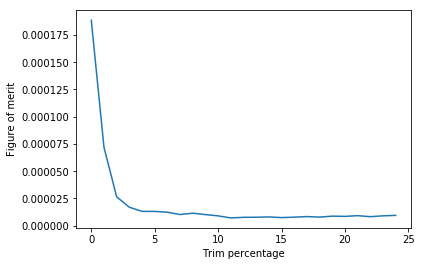

In [15]:
# make plot
plt.plot(trim_percent_range, fig_merit)
plt.xlabel('Trim percentage')
plt.ylabel('Figure of merit')

In [16]:
# optimal trim_percent; done visually
opt_trim_percent = 12
# not very clear where the minimum would be; after a while, it should increase as trim_percent increases 

## Testing the relationship between $t$ and $\frac{x}{X_0}$: calibration curve

Now that all the code is written, it's time to calculate the test statistic for a few values of $\frac{x}{X_0}$. Then we can create a plot to visualize their relationship. We need to do this so that we can find $\frac{x}{X_0}$ as a function of $t$ for our real test data set, since we cannot solve for this relationship analytically.

What values of $\frac{x}{X_0}$ should we use for testing? Well, we want to be sensitive to values of $w_u$ up to 0.2, so we need to find the values of $\frac{x}{X_0}$ corresponding to $w_u=0$ and $w_u=0.2$, and then pick a couple values of $\frac{x}{X_0}$ in the middle to also test.

Looking at the following section, we see that 

$X_0 = w_U/X_U + (1-w_U)/X_A$.

Since we know the values of $X_a$ and $X_u$, we can determine which value of $\frac{x}{X_0}$ corresponds to a given value of $w_u$:

### Generating the fake data: calibration curve
Okay, so now let's generate some fake datasets using these x-ratio values.

In [20]:
ws = np.linspace(0, 0.2, num_test_ws)
x_ratios = []

for w in ws:
    x_ratios.append(get_x_ratio(w))

In [21]:
test_stats = []
count = 0
for x_ratio in x_ratios:
    test_stat_list = monte_carlo(x_ratio, num_monteCarlo, trim_percent=opt_trim_percent)
    test_stats.append(test_stat_list)
    print('Monte carlo finished for w = {}'.format(ws[count]))
    count += 1

Monte carlo finished for w = 0.0
Monte carlo finished for w = 0.022222222222222223
Monte carlo finished for w = 0.044444444444444446
Monte carlo finished for w = 0.06666666666666667
Monte carlo finished for w = 0.08888888888888889
Monte carlo finished for w = 0.11111111111111112
Monte carlo finished for w = 0.13333333333333333
Monte carlo finished for w = 0.15555555555555556
Monte carlo finished for w = 0.17777777777777778
Monte carlo finished for w = 0.2


## Making plots and fitting a line

Slope: 0.004422061040952024
Intercept: 0.004117172043005273


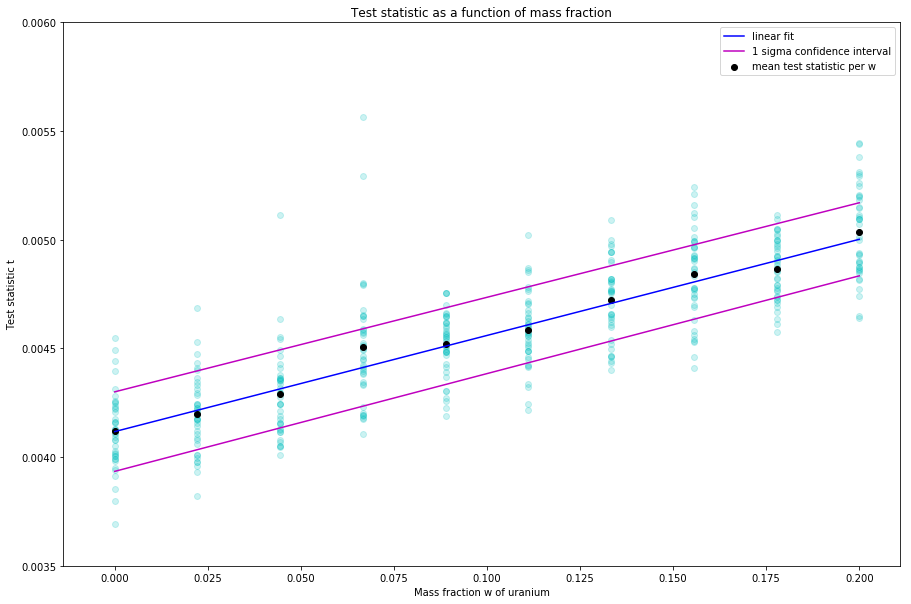

In [22]:
plt.figure(figsize=(15, 10))

for i in range(0, len(ws)):
    plt.scatter([ws[i]]*len(test_stats[i]), test_stats[i], alpha=0.2, c='c')

# find the datapoints (means) and uncertainties (sigmas) for each data point
means = []
sigmas = []
for i in range(0, len(ws)):
    means.append(np.mean(test_stats[i]))
    sigmas.append(np.std(test_stats[i]))
    
# plot the data points
plt.scatter(ws, means, color='k', label='mean test statistic per w')

# fit a line - I'll use a weighted least squares, where the weights are 1/sigma for each point
slope, intercept = np.polyfit(x=ws, y=means, deg=1, w=[1/sigma for sigma in sigmas])
print('Slope: {}\nIntercept: {}'.format(slope, intercept))

# need to fit lines to mean +- sigma, evaluated for each value of w
slope_up, intercept_up = np.polyfit(x=ws, y=np.add(means,sigmas), deg=1, w=[1/sigma for sigma in sigmas])
slope_down, intercept_down = np.polyfit(x=ws, y=np.subtract(means,sigmas), deg=1, w=[1/sigma for sigma in sigmas])

# plot the fit 
test_stats_calc = []
test_stats_calc_up = []
test_stats_calc_down = []
for w in ws:
    foo = slope * w + intercept
    foo_up = slope_up * w + intercept_up
    foo_down = slope_down * w + intercept_down
    test_stats_calc.append(foo)
    test_stats_calc_up.append(foo_up)
    test_stats_calc_down.append(foo_down)
    
plt.plot(ws, test_stats_calc, label='linear fit', c = 'b')
plt.plot(ws, test_stats_calc_up, label='1 sigma confidence interval', c='m')
plt.plot(ws, test_stats_calc_down, c='m')

# format
plt.xlabel('Mass fraction w of uranium')
plt.ylabel('Test statistic t')
plt.title('Test statistic as a function of mass fraction')
plt.ylim(.0035,0.006)
plt.legend()

Looking pretty reasonable!

## Analysis of the sample data

Finally, it is time to analyze the given data. We need to calculate its test statistic, and then we can use that to find its x-ratio, which we can in turn use to find its uranium mass ratio $w_u$. We also need to include some estimate of the uncertainty on $w_u$.

In [23]:
# separate into lists of p and theta 
p = []
theta = []
for i in range(0, len(test_data)):
    if i == 0:
        continue  # remove the first element, num data points
    if i % 2 == 0:
        p.append(test_data[i])
    else:
        theta.append(test_data[i])

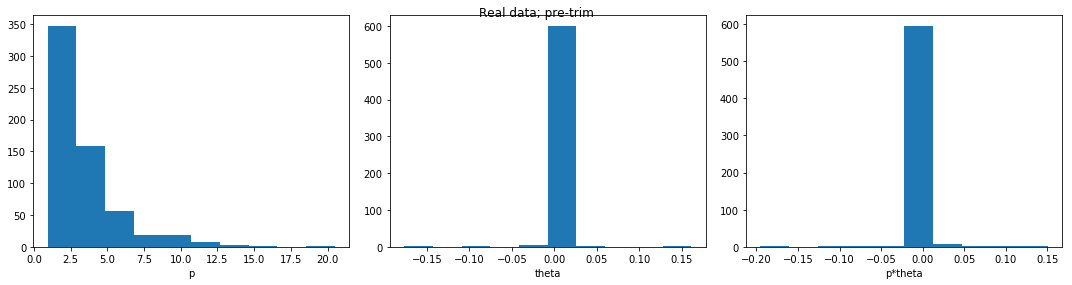

In [24]:
# plot just to get a feel for the data
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.hist(p)
ax1.set_xlabel('p')
ax2.hist(theta)
ax2.set_xlabel('theta')
ax3.hist(np.multiply(p, theta))
ax3.set_xlabel('p*theta')
f.set_figwidth(15)
f.tight_layout()
plt.suptitle('Real data; pre-trim')

There are outliers and I need to trim this data.

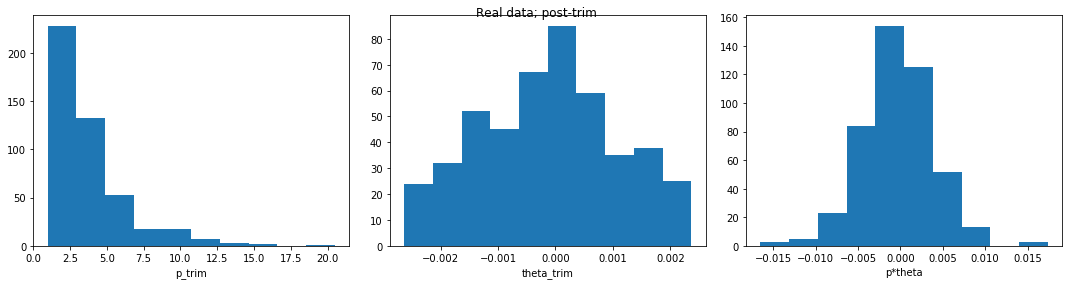

In [25]:
p_trim, theta_trim = trim_range(p=p, theta=theta, trim_percent=trim_percent)

f, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.hist(p_trim)
ax1.set_xlabel('p_trim')
ax2.hist(theta_trim)
ax2.set_xlabel('theta_trim')
ax3.hist(np.multiply(p_trim, theta_trim))
ax3.set_xlabel('p*theta')
f.set_figwidth(15)
f.tight_layout()
plt.suptitle('Real data; post-trim')

In [26]:
# evaluate the test statistic
test_stat = evaluate_testStat(p_trim, theta_trim)
print('Test stat value for test sample: {}'.format(test_stat))

# use the results of the linear regression to get its corresponding value of w
w = (test_stat - intercept)/slope

# get the standard deviation
error = abs(w - (test_stat - intercept_up)/slope_up)

print ('Mass fraction of uranium in test sample: {} +- {}'.format(w, error))

Test stat value for test sample: 0.004239112397268313
Mass fraction of uranium in test sample: 0.02757545704000221 +- 0.041589971031439965


In [27]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

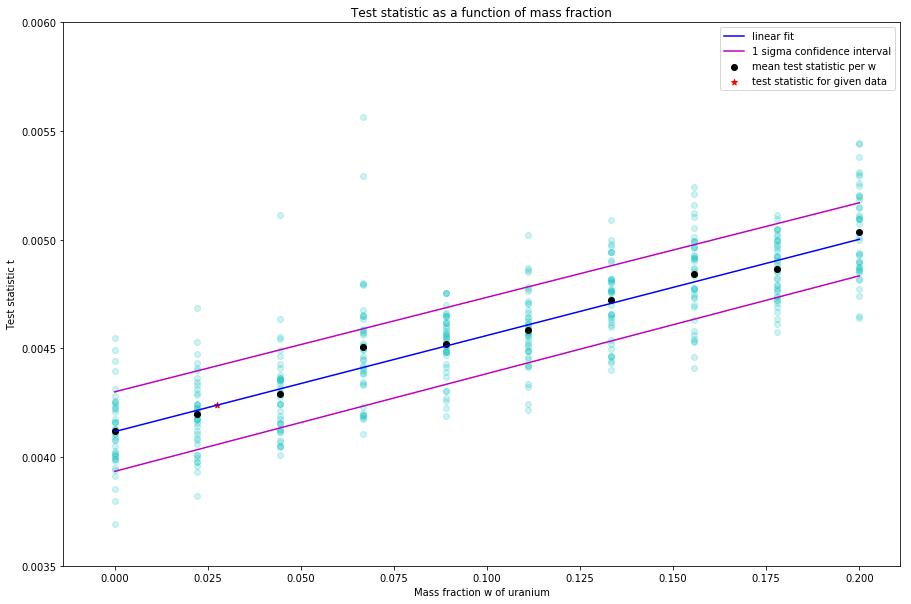

In [28]:
plt.figure(figsize=(15, 10))

# plot sample test stats
for i in range(0, len(ws)):
    plt.scatter([ws[i]]*len(test_stats[i]), test_stats[i], alpha=0.2, c='c')
    
# plot the data points
plt.scatter(ws, means, color='k', label='mean test statistic per w')

# plot the fit    
plt.plot(ws, test_stats_calc, label='linear fit', c = 'b')
plt.plot(ws, test_stats_calc_up, label='1 sigma confidence interval', c='m')
plt.plot(ws, test_stats_calc_down, c='m')

# plot the real datapoint
plt.scatter(w, test_stat, marker='*', c='r', label='test statistic for given data')

# format
plt.xlabel('Mass fraction w of uranium')
plt.ylabel('Test statistic t')
plt.title('Test statistic as a function of mass fraction')
plt.ylim(0.0035, 0.006)
plt.legend()